**Modeling filter adsorption of Stelara IV: current status  
P. Yao  
PDMS LM DPD  
20.02.2018**

***Summary:*** Protein adsorption is a common occurence during sterile filtration. It can be modeled as an adsorption to a fixed-bed adsorber, which is a well-studied operation. This notebook documents our current attempts to apply such an approach.

Although the model can fit the single-filter experimental data, it does not predict accurately the behaviour seen in the two-filter experiment. It cannot account for the initial large drop in concentration that was observed in the single-filter experiment without assuming that the initial state is *past* the equilibrium point, with *more* protein adsorbed during the holding period before filtration, than at the end of filtration. We will need to consider further modifications to the model equations to account for the seeminlg rapid initial adsorption.

*Import libraries and set plotting options*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import linregress
import lmfit
import copy
import graphviz

plt.ioff()
plt.style.use('bmh')
%config InlineBackend.figure_format = 'svg'

%load_ext watermark

The watermark command lists the current package versions

%watermark -v -p numpy,pandas,matplotlib,scipy,lmfit

CPython 3.6.4  
IPython 6.2.1  

numpy 1.14.0  
pandas 0.22.0  
matplotlib 2.1.2  
scipy 1.0.0  
lmfit 0.9.7

*Load data from files and set constants*

In [2]:
exp_data1 = pd.read_csv('data_onefilter.txt', delimiter='\t', index_col=False)
time1 = exp_data1['time'].values
concentration1 = exp_data1['concentration'].values
volume1 = exp_data1['volume'].values

exp_data2 = pd.read_csv('data_twofilters.txt', delimiter='\t', index_col=False)
time2 = exp_data2['time'].values
concentration2 = exp_data2['concentration'].values
volume2 = exp_data2['volume'].values

Vol = 670  # mL, measured by filling with water (LS and ZP)
c_input = 4.94  # mg/mL
c_init = concentration1[0]  # ca. 3.0 mg/mL
q_init = c_input - c_init  # ca. 1.9 mg/mL

linfit1 = linregress(time1, volume1)
Vdot1 = linfit1.slope  # ca. 0.38 mL/s

linfit2 = linregress(time2, volume2)
Vdot2 = linfit2.slope  # ca. 1.42 mL/s

***Part 1: Fitting the single-filter FlowVPE data from CNTO 1275 N004-02373 (LS & ZP)***

*Model description*

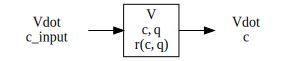

In [3]:
# This code block generates the diagram below.

dia1 = graphviz.Digraph()
dia1.graph_attr['rankdir'] = 'LR'
dia1.node('in', label='Vdot\nc_input', color='white')
dia1.node('reactor', label='V\nc, q\n r(c, q)', shape='box')
dia1.node('out', label='Vdot\nc', color='white')
dia1.edge('in', 'reactor')
dia1.edge('reactor','out')
dia1

The reaction $r(c, q)$ consumes $c$ and generates $q$, and is modeled as $r(c, q) = k_1 c (q_{max} - q) - k_2 q$ (a pseudo second-order adsorption, first order desorption reaction)

Concentration in liquid phase, $c$
$$\frac{dc}{dt} = \frac{\dot{V}}{V} (c_{input} - c) - r(c,q) = \frac{\dot{V}}{V} (c_{input} - c) - k_1 c (q_{max} - q) + k_2 q$$

Concentration in adsorbed phase, $q$
$$\frac{dq}{dt} = r(c,q) = k_1 c (q_{max} - q) - k_2 q$$

Note: at equilibrium $\frac{dq}{dt} = 0$ and $q = q_{max} \frac{(k_1/k_2) c_e}{1 + (k_1/k_2) c_e}$ (Langmuir isotherm)

*Model equations translated to functions*

(Note that the function `conf_index()` is needed because the `conc()` function returns both $c$ and $q$ values, while we only have experimental $c$ values; therefore we need the function that will be passed to create the  `lmfit.Model` object to return only the $c$ values. DO already suggested a cleaner solution using a `lambda` function , but since we want to look at the $q$ values anyway, I will keep it so.)

In [4]:
def rates(state, t, paras):
    c, q = state
    k1, k2, qmax, vol, vdot = paras

    dcdt = vdot / vol * (c_input - c) - k1 * c * (qmax - q) + k2 * q
    dqdt = k1 * c * (qmax - q) - k2 * q
    return [dcdt, dqdt]


def conc(t, c0, q0, k1, k2, qmax, v, vdot):
    initial_state = (c0, q0)
    params_list = [k1, k2, qmax, v, vdot]

    x = odeint(rates, initial_state, t, args=(params_list, ))
    return x


def conc_index(t, c0, q0, k1, k2, qmax, index, v, vdot):
    x = conc(t, c0, q0, k1, k2, qmax, v, vdot)
    return x[:, index]

*Create the `lmfit.Model` object, the `lmfit.Parameter` object, and set the parameter options*

The reaction $r(c,q)$ has three parameters: $k_1$ (adsorption rate constant), $k_2$ (desorption rate constant), and $q_{max}$ (adsorbed phase concentration at equilibrium).

Instead of using $q_{max}$ as a fitting parameter, we can try to estimate it by calculating how much protein mass is left in the filter at the end of the run, and dividing by the filter volume.

In [5]:
c_model = lmfit.Model(conc_index, independent_vars=['t', 'index'])

In [6]:
protein_loss = (volume1[1:]-volume1[:-1]) * c_input - (volume1[1:]-volume1[:-1]) * concentration1[1:]

In [7]:
params = c_model.make_params()

params['k1'].value = 0.01
params['k2'].value = 0.001
params['qmax'].value = protein_loss.sum() / Vol

params['c0'].value = c_init
params['q0'].value = q_init
params['v'].value = Vol
params['vdot'].value = Vdot1

params['k1'].vary = True
params['k2'].vary = True
params['qmax'].vary = False  # Note that qmax will be fixed
params['c0'].vary = False
params['q0'].vary = False
params['v'].vary = False
params['vdot'].vary = False

*Fit the model to the data*

In [8]:
lmfit_results = c_model.fit(concentration1, params, t=time1, index=0, method='nelder')
print(lmfit_results.fit_report())

[[Model]]
    Model(conc_index)
[[Fit Statistics]]
    # function evals   = 71
    # data points      = 51
    # variables        = 2
    chi-square         = 0.081
    reduced chi-square = 0.002
    Akaike info crit   = -324.586
    Bayesian info crit = -320.722
[[Variables]]
    c0:     3.023799 (fixed)
    q0:     1.916201 (fixed)
    k1:     0.00092836 (init= 0.01)
    k2:     8.2254e-06 (init= 0.001)
    qmax:   0.28567 (fixed)
    v:      670 (fixed)
    vdot:   0.3784777 (fixed)



Graphical evaluation of the fit. Note that $q$ (adsorbed phase concentration) *decreases* from its initial value, already a sign of a problem with the model.

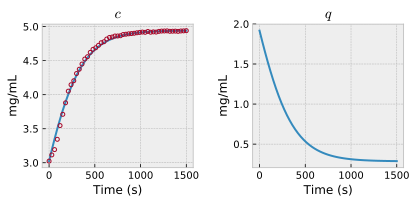

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(time1, lmfit_results.eval(index=0))
ax1.plot(time1, concentration1, marker='o', markerfacecolor='None', 
        linestyle='None', markersize=4)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c$')

ax2.plot(time1, c_model.eval(lmfit_results.params, t=time1, index=1))
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q$')

fig.set_size_inches(15/2.54, 7.5/2.54)
fig.tight_layout()
# fig.show()  # This is done automatically in notebooks and will raise a warning if uncommented

Save the fit parameter values for later:

In [10]:
k1_lmfit = lmfit_results.params['k1'].value
k2_lmfit = lmfit_results.params['k2'].value
qmax_lmfit = lmfit_results.params['qmax'].value  # This will be the fixed value calculated above

***Part 2: Simulating two filters in series and compare to CNTO 1275 N004-02388 (LS and ZP)***

*Model description*

The rates are defined in a similar way to the single filter. For the input of filter 2 we use the output of filter 1. Naturally we assume that $k_1$, $k_2$, and $q_{max}$ are the same for both filters.

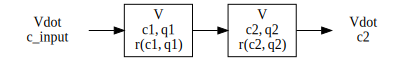

In [11]:
# This code block generates the diagram below.

dia2 = graphviz.Digraph()
dia2.graph_attr['rankdir'] = 'LR'
dia2.node('in', label='Vdot\nc_input', color='white')
dia2.node('reactor1', label='V\nc1, q1\n r(c1, q1)', shape='box')
dia2.node('reactor2', label='V\nc2, q2\n r(c2, q2)', shape='box')
dia2.node('out', label='Vdot\nc2', color='white')
dia2.edge('in', 'reactor1')
dia2.edge('reactor1', 'reactor2')
dia2.edge('reactor2','out')
dia2

Filter 1:
$$\frac{dc_1}{dt} = \frac{\dot{V}}{V} (c_{input} - c_1) - k_1 c_1 (q_{max} - q_1) + k_2 q_1$$
$$\frac{dq_1}{dt} = k_1 c_1 (q_{max} - q_1) - k_2 q_1$$

Filter 2:
$$\frac{dc_2}{dt} = \frac{\dot{V}}{V} (c_1 - c_2) - k_1 c_2 (q_{max} - q_2) + k_2 q_2$$
$$\frac{dq_2}{dt} = k_1 c_2 (q_{max} - q_2) - k_2 q_2$$

*Model equations translated to functions*

For now I just translate this directly to python functions. As suggested by DO, it would be interesting to write a more general (recursive) function for $n$ filters in series. This could potentially be used to model unsteady-state adsorption in a plug-flow adsorber as a PFR with a very large $n$.

(I have not yet changed this code to use `lmfit`)

In [12]:
def rates_twofilters(state, t, paras):
    c1, q1, c2, q2 = state
    k1, k2, qmax, vol, vdot = paras

    dc1dt = vdot / vol * (c_input - c1) - k1 * c1 * (qmax - q1) + k2 * q1
    dq1dt = k1 * c1 * (qmax - q1) - k2 * q1

    dc2dt = vdot / vol * (c1 - c2) - k1 * c2 * (qmax - q2) + k2 * q2
    dq2dt = k1 * c2 * (qmax - q2) - k2 * q2
    return [dc1dt, dq1dt, dc2dt, dq2dt]


def conc_twofilters(t, initial_state, paras):
    x = odeint(rates_twofilters, initial_state, t, args=(paras,))
    return x

*First simulation attempt*

As a first attempt, we can ignore the time needed to fill the second filter and the holding time.

Note that we do not have $c_{1,initial}$ and $q_{1,initial}$ from this experiment, so we must assume that they are the same as in the single-filter experiment.

For $c_{2,initial}$ and $q_{2,initial}$, we will use $c_{1,initial} = c_{2,initial}$ and $q_{2,initial} = 0$.

In [13]:
init_state = c_init, q_init, c_init, 0

Simulate over 50 min:

In [14]:
t_collect = np.arange(0, 3001, 10)
twofilters = conc_twofilters(t_collect, init_state, [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

Plot the results:

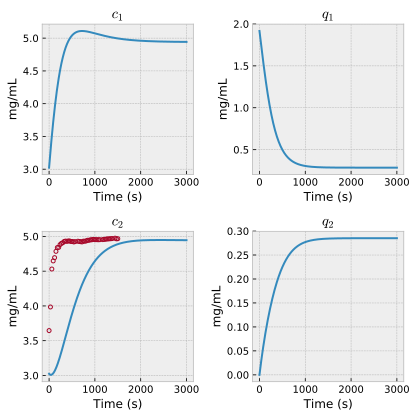

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(t_collect, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(t_collect, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(t_collect, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(t_collect, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
# fig.show()

*Second attempt*

Let's try to incorporate the filling and holding operations, in order to obtain "better" initial values ($c_{1,initial}$, $q_{1,initial}$, $c_{2,initial}$, $q_{2,initial}$)

*Filling*

We will simulate filling the second filter using the output of the first filter.

Simulating the filling operation will be very complicated if we try to account for adsorption in the second filter, because the volume changes over time. As a first approximation, we ignore the adsorption in the second filter during filling.

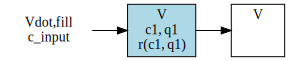

In [16]:
# This code block generates the diagram below.

dia3 = graphviz.Digraph()
dia3.graph_attr['rankdir'] = 'LR'
dia3.node('in', label='Vdot,fill\nc_input', color='white')
dia3.node('reactor1', label='V\nc1, q1\n r(c1, q1)', shape='box', 
          style='filled', fillcolor='lightblue')
dia3.node('reactor2', label='V\n \n ', shape='box')
dia3.edge('in', 'reactor1')
dia3.edge('reactor1', 'reactor2')
dia3

In [17]:
Vdot_fill = 670 / 16  # 670 mL / 16 s = 41.875 mL/s

v_fill = np.arange(0, 670, 1)
t_fill = v_fill / Vdot_fill

fill = c_model.eval(lmfit_results.params, vdot=Vdot_fill, t=t_fill, index=[0,1])

For the concentration in the second filter, we calculate the cumulative mass as $m = \int_{0}^{t_{fill}} \dot{V}_{fill} c_2(t) dt$

In [18]:
avg_fill = np.trapz(Vdot_fill * fill[:,0],x=t_fill) / 670

*Holding*

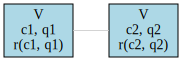

In [19]:
# This code block generates the diagram below.

dia4 = graphviz.Digraph()
dia4.graph_attr['rankdir'] = 'LR'
dia4.node('reactor1', label='V\nc1, q1\n r(c1, q1)', shape='box', 
          style='filled', fillcolor='lightblue')
dia4.node('reactor2', label='V\nc2, q2\n r(c2, q2)', shape='box', 
          style='filled', fillcolor='lightblue')
dia4.edge('reactor1', 'reactor2', arrowhead='None', color='lightgrey')
dia4

We use the endpoint values of the filling operation as the initial values for holding (5 min).

Filter 1: $c_{1,hold,initial} = c_{1, fill,final}$ and  $q_{1,hold,initial} = q_{1, fill,final}$

Filter 2: $c_{2,hold,initial} = \frac{\int_{0}^{t_{fill}} \dot{V}_{fill} c_{2,fill}(t) dt}{V}$ and 
$q_{2,hold,initial} = 0$

In [20]:
t_hold = np.arange(0,300,1)

hold1 = c_model.eval(lmfit_results.params, c0=fill[-1,0], q0=fill[-1,1], 
                     vdot=0, t=t_hold, index=[0,1])

hold2 = c_model.eval(lmfit_results.params, c0=avg_fill, q0=0, 
                     vdot=0, t=t_hold, index=[0,1])

*Collecting*

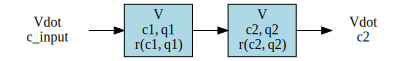

In [21]:
# This code block generates the diagram below.

dia5 = graphviz.Digraph()
dia5.graph_attr['rankdir'] = 'LR'
dia5.node('in', label='Vdot\nc_input', color='white')
dia5.node('reactor1', label='V\nc1, q1\n r(c1, q1)', shape='box', 
          style='filled', fillcolor='lightblue')
dia5.node('reactor2', label='V\nc2, q2\n r(c2, q2)', shape='box', 
          style='filled', fillcolor='lightblue')
dia5.node('out', label='Vdot\nc2', color='white')
dia5.edge('in', 'reactor1')
dia5.edge('reactor1', 'reactor2')
dia5.edge('reactor2','out')
dia5

The final values of the holding operation become the initial values of the collecting operation.

In [22]:
init_state = hold1[-1,0], hold1[-1,1], hold2[-1,0], hold2[-1,1]

Simulate over 50 min:

In [23]:
t_collect = np.arange(0, 3001, 10)
twofilters = conc_twofilters(t_collect, init_state, [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

Plot the results:

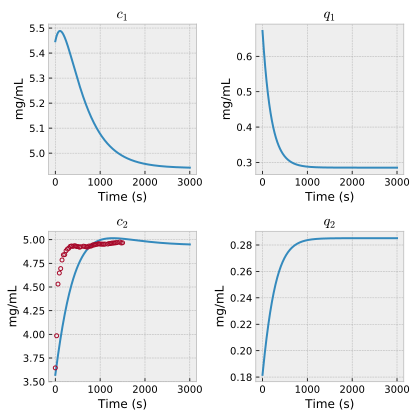

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(t_collect, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(t_collect, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(t_collect, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(t_collect, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
# fig.show()

The model still does not capture the experimental behavior.

The simulated $q_1$ trend indicates a clear problem. The estimated value of $q_{max}$ is much lower than the initial adsorbed concentration $q_{1,initial}$, and the model predicts that the system will trend towards equilibrium by *desorption* of the adsorbed phase. Note also that in the $c_1$ trend, the concentration is initially much higher than $c_{input}$, again because of (simulated) desorption during the holding operation.

Basically the form of the reaction $r(c,q) = k_1 c (q_{max} - q) - k_2 q$ cannot simultaneously account for the rapid initial adsorption (leading to low $c_{initial}$) and the comparatively slow equilibration during the filtration, without assuming that the initial point is on the "wrong" (overly adsorbed) side of the equilibrium.